# Stock Price Prediction

In [1]:
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler # Skalieren von Datensätzen (aus Sckit)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.utils import plot_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

In [2]:
plt.style.use("fivethirtyeight")

In [3]:
# Kursdaten von Yahoo-Finance importieren
data = yf.download('BTC-USD', start="2017-01-01", end = "2022-01-01")

[*********************100%%**********************]  1 of 1 completed


In [4]:
data['Date'] = data.index
btc_data = pd.DataFrame(columns = ['Price'])
btc_data['Price'] = data['Adj Close']

In [5]:
missing_values = btc_data.isnull().sum()
missing_per = (missing_values/btc_data.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total fehlende Werte',1:'fehlende Werte in %'}, inplace=True)
missing_table

,Total fehlende Werte,fehlende Werte in %
Price,0,0.0


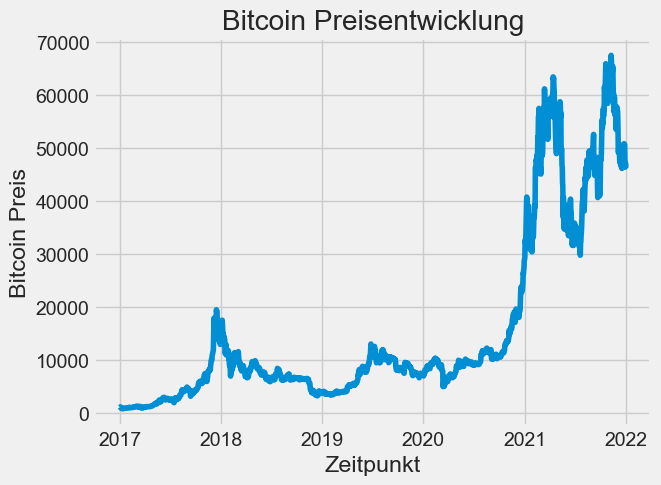

In [6]:
plt.plot(btc_data)
plt.title('Bitcoin Preisentwicklung')
plt.xlabel('Zeitpunkt')
plt.ylabel('Bitcoin Preis')
plt.show()

In [7]:
renditen = pd.DataFrame(columns=['Rendite'])
renditen['Rendite'] = np.log(btc_data['Price']/ btc_data['Price'].shift(1))

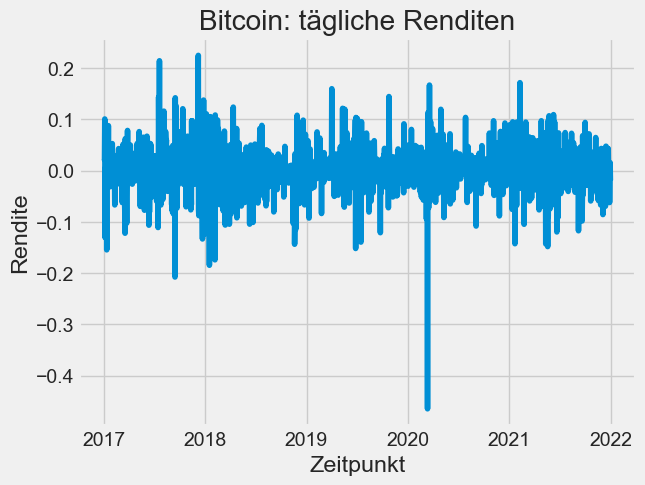

In [8]:
plt.plot(renditen)
plt.title('Bitcoin: tägliche Renditen')
plt.xlabel('Zeitpunkt')
plt.ylabel('Rendite')
plt.show()

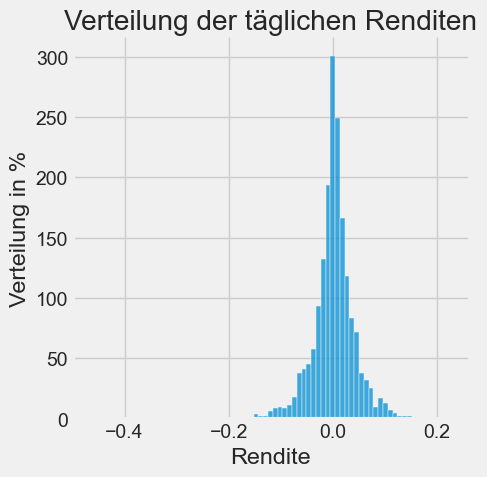

In [9]:
sns.displot(renditen['Rendite'], bins=75)
plt.xlabel('Rendite')
plt.ylabel('Verteilung in %')
plt.title('Verteilung der täglichen Renditen')
plt.tight_layout()

In [10]:
split_date = '01-Oct-2021'
data_train = btc_data.loc[btc_data.index <= split_date].copy()
data_test = btc_data.loc[btc_data.index > split_date].copy()

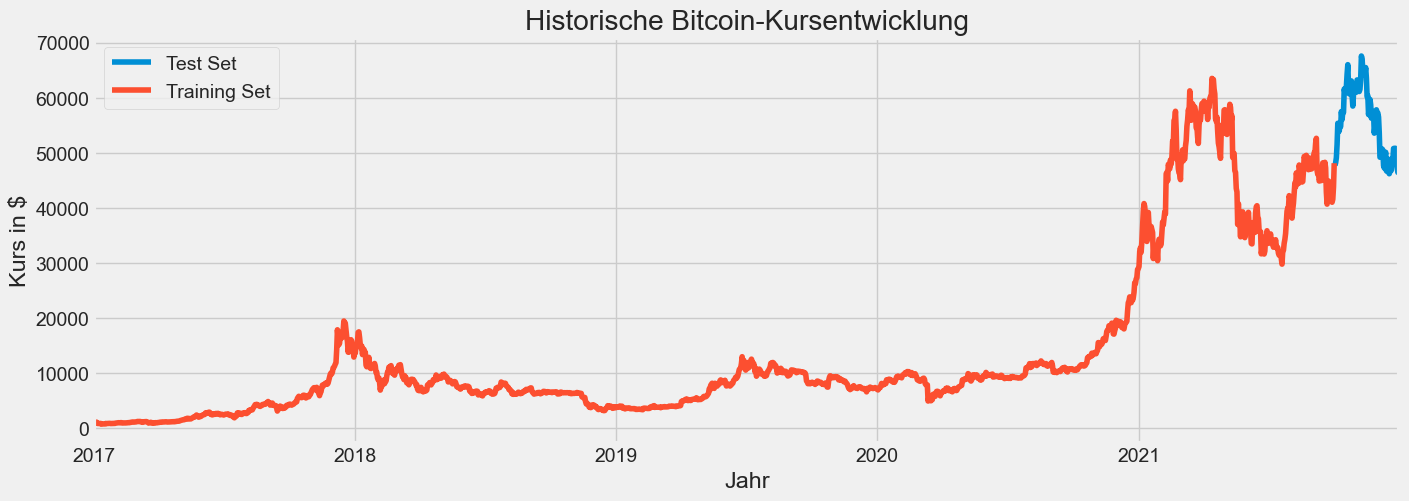

In [11]:
_ = data_test \
    .rename(columns={'Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='Historische Bitcoin-Kursentwicklung', xlabel = 'Jahr', ylabel = 'Kurs in $', style='')

In [12]:
dataset = btc_data.values

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [14]:
training_data_len = int(np.ceil( len(data_train)))
data_train = scaled_data[0:int(training_data_len), :]
data_test = scaled_data[training_data_len - 60: , :]

In [15]:
x_train = []
y_train = []

for i in range(60, len(data_train)):
    x_train.append(data_train[i-60:i, 0])
    y_train.append(data_train[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(data_test)):
    x_test.append(data_test[i-60:i, 0])

[array([0.00330246, 0.00365319, 0.00398393, 0.00564423, 0.00352787,
       0.00186324, 0.00195882, 0.00199796, 0.00187263, 0.00194526,
       0.        , 0.00040541, 0.00069213, 0.00060871, 0.0006594 ,
       0.00080518, 0.00194914, 0.00162992, 0.0018164 , 0.00175581,
       0.00215652, 0.0021997 , 0.00214489, 0.00172079, 0.00185337,
       0.00209359, 0.00212599, 0.00215354, 0.00212219, 0.00213545,
       0.00288439, 0.00316318, 0.00350421, 0.00377536, 0.00396986,
       0.00373688, 0.00389874, 0.0042461 , 0.00427185, 0.00324343,
       0.00315796, 0.00339416, 0.00331527, 0.00318742, 0.00339566,
       0.00343953, 0.00373838, 0.00401941, 0.00414234, 0.00404427,
       0.00452504, 0.00505387, 0.00508591, 0.00582375, 0.00592796,
       0.00548118, 0.00580099, 0.00602214, 0.00602214, 0.00665892])]
[0.007085784887947722]

[array([0.00330246, 0.00365319, 0.00398393, 0.00564423, 0.00352787,
       0.00186324, 0.00195882, 0.00199796, 0.00187263, 0.00194526,
       0.        , 0.00040541, 0.0

In [16]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_test = np.array(x_test)

In [17]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [18]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\Miro\IdeaProjects\tech-charts\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model_historische_daten = model.fit(x_train,
                                    y_train, 
                                    batch_size=10, 
                                    epochs=1, 
                                    verbose = 1)

model.summary()
plot_model(model)

168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0062


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 363,905 (1.39 MB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 242,604 (947.68 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [20]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


In [21]:
valid = data[training_data_len:]
valid['Predictions'] = predictions
valid

C:\Users\Miro\AppData\Local\Temp\ipykernel_17276\3973297343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


,Open,High,Low,Close,Adj Close,Volume,Date,Predictions
Date,,,,,,,,
2021-10-02,48137.468750,48282.062500,47465.496094,47711.488281,47711.488281,30614346492,2021-10-02,39676.816406
2021-10-03,47680.027344,49130.691406,47157.289062,48199.953125,48199.953125,26638115879,2021-10-03,40072.882812
2021-10-04,48208.906250,49456.777344,47045.003906,49112.902344,49112.902344,33383173002,2021-10-04,40594.816406
2021-10-05,49174.960938,51839.984375,49072.839844,51514.812500,51514.812500,35873904236,2021-10-05,41214.558594
2021-10-06,51486.664062,55568.464844,50488.191406,55361.449219,55361.449219,49034730168,2021-10-06,41992.335938
...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,2021-12-27,44519.972656
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,2021-12-28,44852.660156
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,2021-12-29,44970.839844


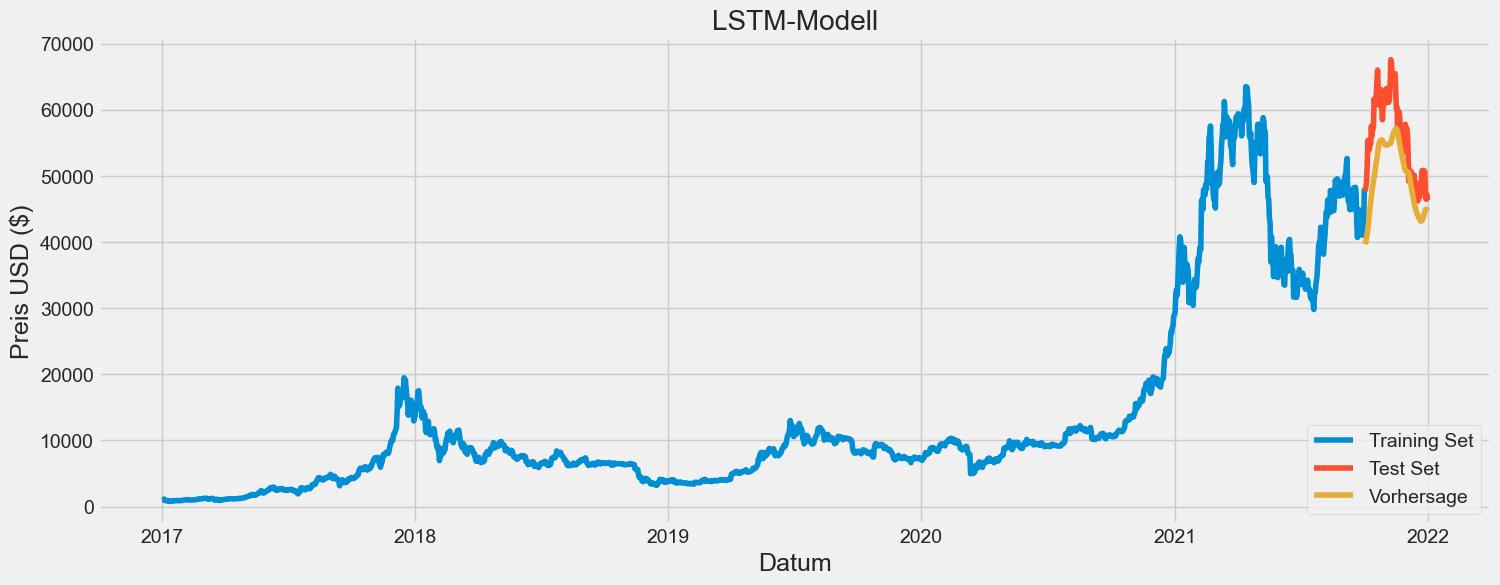

In [22]:
plt.figure(figsize=(16,6))
plt.title('LSTM-Modell')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Preis USD ($)', fontsize=18)
plt.plot(data[:training_data_len]['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Training Set', 'Test Set', 'Vorhersage'], loc='lower right')
plt.show()

In [ ]:
plt.figure(figsize=(16,6))
plt.title('LSTM-Modell')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Preis USD ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Kurs', 'Vorhersage'], loc='lower right')
plt.show()

In [24]:
# Mean Absolute Error berechnen
mae = mean_absolute_error(y_true=valid['Close'],
                   y_pred=valid['Predictions'])

# Mean Squared Error berechnen
mse = mean_squared_error(y_true=valid['Close'],
                   y_pred=valid['Predictions'])

# Root Mean Squared Error berechnen
rmse = sqrt(mse)

# R-Square berechnen
r2 = r2_score(y_true=valid['Close'],
                   y_pred=valid['Predictions'])

print(' Der Mean Absolute Error beträgt', mae, '\n',
      'Der Mean Squared Error beträgt', mse, '\n',
      'Der Root Mean Squared Error beträgt', rmse, '\n',
      'Der R-Square beträgt', r2)

 Der Mean Absolute Error beträgt 5989.572458791209 
 Der Mean Squared Error beträgt 46520535.0772202 
 Der Root Mean Squared Error beträgt 6820.596387209861 
 Der R-Square beträgt -0.2109486228682489
